<a href="https://colab.research.google.com/github/peculab/DFTDescriptorPipeline/blob/main/notebooks/Colab_Demo_DFTDescriptorPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!fuser -k /content/DFTDescriptorPipeline || true
!rm -rf /content/DFTDescriptorPipeline

Specified filename /content/DFTDescriptorPipeline does not exist.


In [2]:
# Step 1: Clone fresh from GitHub
!git clone https://github.com/peculab/DFTDescriptorPipeline.git

# Step 2: Move into the cloned directory
%cd DFTDescriptorPipeline

# Step 3: Install requirements
!pip install -r requirements.txt

# Step 4: Set Python module path
import sys
sys.path.append(".")

# Step 5: Import your package successfully
from descriptors.aggregate import generate_feature_table
from descriptors.extractor import extract_homo_lumo, extract_dipole_moment, extract_polarizability
from descriptors.sterimol import find_oh_bonds, find_c1_c2

Cloning into 'DFTDescriptorPipeline'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 68 (delta 30), reused 45 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 4.40 MiB | 5.24 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/DFTDescriptorPipeline


In [3]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

In [4]:
!pip install -U scikit-learn

In [5]:
# STEP 1: Automatically extract descriptors from logfiles
df_features = generate_feature_table("logfiles")

# STEP 2: Read the experimental data Heck_boronic_acid.xlsx (need to be placed in data/)
ddg_df = pd.read_excel("data/Heck_boronic_acid.xlsx")
ddg_df.columns = ["name", "ddG"]
df = df_features.merge(ddg_df, on="name")

# STEP 3: Specify feature fields and model
X = df[["Ar_HOMO", "Ar_dp", "Ar_polar"]]
y = df["ddG"]

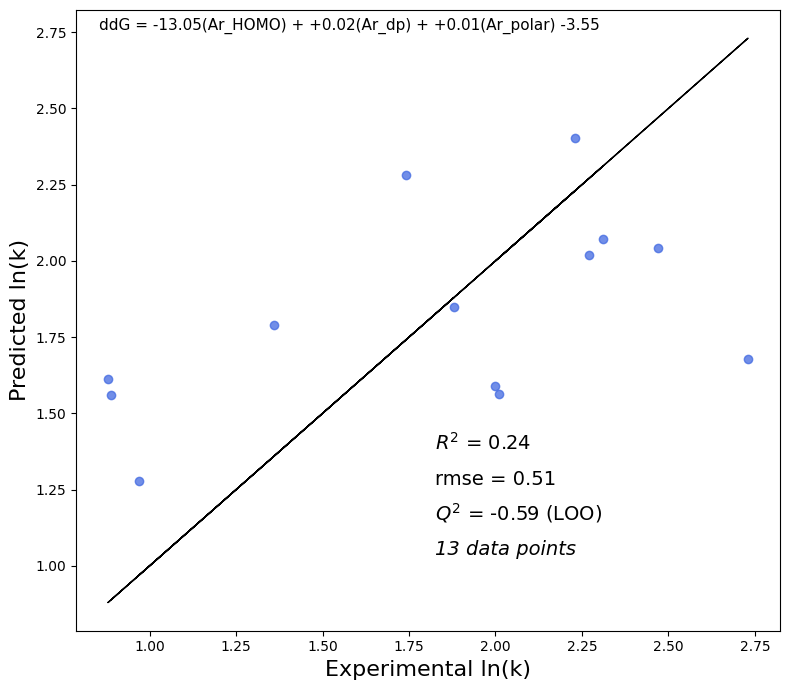

In [6]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# LOO Q²
loo = LeaveOneOut()
q2_pred = []
for train_idx, test_idx in loo.split(X):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    q2_pred.append(model.predict(X.iloc[test_idx])[0])
q2 = 1 - mean_squared_error(y, q2_pred) / np.var(y)

# Statistics and formulas
r2 = model.score(X, y)
rmse = np.sqrt(mean_squared_error(y, y_pred))
n_points = len(y)
eqn = " + ".join([f"{coef:+.2f}({name})" for coef, name in zip(model.coef_, X.columns)])
intercept = f"{model.intercept_:+.2f}"
formula = f"ddG = {eqn} {intercept}"

# Start drawing
fig, ax = plt.subplots(figsize=(8, 7))
ax.set_facecolor('white')

# Ideal diagonal y = x
ax.plot(y, y, 'k-', linewidth=1)

# Scatter plot
ax.scatter(y, y_pred, edgecolor='royalblue', facecolor='royalblue', alpha=0.75)

# Coordinates and labels
ax.set_xlabel("Experimental ln(k)", fontsize=16, color='k')
ax.set_ylabel("Predicted ln(k)", fontsize=16, color='k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Use proportional coordinates (figure.text) to mark text to avoid position deviation
fig.text(0.13, 0.95, formula, fontsize=11)
fig.text(0.55, 0.35, f"$R^2$ = {r2:.2f}", fontsize=14)
fig.text(0.55, 0.30, f"rmse = {rmse:.2f}", fontsize=14)
fig.text(0.55, 0.25, f"$Q^2$ = {q2:.2f} (LOO)", fontsize=14)
fig.text(0.55, 0.20, f"{n_points} data points", fontsize=14, style='italic')

# Layout adjustment and display
fig.tight_layout()
plt.grid(False)
plt.show()